# Mismatch test of `IMRPhenomXAS_NRTidalv3`

There are several tests to be done:
- [ ] Compare mismatch with `LALSimulation`
- [ ] Recover XAS limit when $\Lambda_{1,2} \to 0$, in `ripple`

In [74]:
# Skip the complex to real warnings and the LAL warnings
import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import lal
from lal import MSUN_SI, MTSUN_SI, PC_SI
import lalsimulation as lalsim
from lalsimulation import IMRPhenomXAS, IMRPhenomXAS_NRTidalv3
MPC_SI = PC_SI * 1e6
print(lalsim.__version__)

6.2.0


In [ ]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from jax.scipy.integrate import trapezoid
import numpy as np
import matplotlib.pyplot as plt

from ripplegw import ms_to_Mc_eta, lambdas_to_lambda_tildes
from ripplegw.waveforms.IMRPhenomXAS import gen_IMRPhenomXAS_hphc
from ripplegw.waveforms.IMRPhenomXAS_NRTidalv3 import gen_IMRPhenomXAS_NRTidalv3_hphc

In [3]:
# Choose the ET PSD just to have the wide frequency range
psd_freqs, *psd_arrs = np.loadtxt("psds/ET-D-psd.txt", unpack=True)
psd_arr = psd_arrs[0]

In [19]:
def get_freq_array(sampling_freqs, duration):
    # Build the frequency grid
    delta_t = 1 / sampling_freqs
    tlen = int(round(duration * sampling_freqs))
    freqs = jnp.fft.rfftfreq(tlen, delta_t)
    return freqs


def noise_weighted_inner_product(h1, h2, psd, frequencies):
    integrand = jnp.conj(h1) * h2 / psd
    return 4 * trapezoid(integrand, x=frequencies, axis=-1).real


def compute_match(h1, h2, psd, frequencies):
    h1_sq = noise_weighted_inner_product(h1, h1, psd, frequencies)
    h2_sq = noise_weighted_inner_product(h2, h2, psd, frequencies)
    h1_h2 = noise_weighted_inner_product(h1, h2, psd, frequencies)
    match = h1_h2 / jnp.sqrt(h1_sq * h2_sq)
    return match.real
    

In [47]:
fs = 8192

# Yes, I should have combined the XAS and tidal functions, I am lazy.

def lal_XAS_waveform(mass_1, mass_2, a_1, a_2, inclination, phase, Lambda_1, Lambda_2,
                     duration, f_min, f_max, reference_frequency):

    lal_hpc = lalsim.SimInspiralChooseFDWaveform(
        mass_1 * MSUN_SI,
        mass_2 * MSUN_SI,
        0, 0, a_1, 
        0, 0, a_2, 
        1,  # m
        inclination, phase,
        0., 0., 0.,
        1.0 / duration,
        f_min, f_max, 
        reference_frequency, 
        None,
        IMRPhenomXAS
    )
    hpc_len = len(lal_hpc[0].data.data)

    frequencies = get_freq_array(sampling_freqs=fs, duration=duration)
    zeros = jnp.zeros_like(frequencies, dtype=jnp.complex128)
    hp = zeros.at[:hpc_len].set(lal_hpc[0].data.data)
    hc = zeros.at[:hpc_len].set(lal_hpc[1].data.data)

    return frequencies, hp, hc


def ripple_XAS_waveform(mass_1, mass_2, a_1, a_2, inclination, phase, Lambda_1, Lambda_2,
                        duration, f_min, f_max, reference_frequency):

    frequencies = get_freq_array(sampling_freqs=fs, duration=duration)
    frequency_mask = (frequencies >= f_min) & (frequencies <= f_max)

    ones = jnp.ones_like(mass_1)
    chirp_mass, symmetric_mass_ratio = ms_to_Mc_eta(jnp.array([mass_1, mass_2]))

    thetas = jnp.array([
        chirp_mass, symmetric_mass_ratio, a_1, a_2, 
        ones/MPC_SI, ones*0., phase, inclination
    ])

    zeros = jnp.zeros_like(frequencies, dtype=jnp.complex128)

    @jax.jit
    def waveform(theta):
        hpc = gen_IMRPhenomXAS_hphc(
            frequencies[frequency_mask],
            theta, reference_frequency
        )
        hp = zeros.at[frequency_mask].set(hpc[0])
        hc = zeros.at[frequency_mask].set(hpc[1])
        return hp, hc

    if thetas[0].size > 1:
        ripple_hpc = jax.vmap(waveform)(thetas.T)
    else:
        ripple_hpc = waveform(thetas)

    return frequencies, *ripple_hpc


def lal_NRTidalv3_waveform(mass_1, mass_2, a_1, a_2, inclination, phase, Lambda_1, Lambda_2,
                           duration, f_min, f_max, reference_frequency):

    laldict = lal.CreateDict()
    lalsim.SimInspiralWaveformParamsInsertTidalLambda1(laldict, Lambda_1)
    lalsim.SimInspiralWaveformParamsInsertTidalLambda2(laldict, Lambda_2)
    quad1 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(Lambda_1)
    quad2 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(Lambda_2)
    # Note that these are dquadmon, not quadmon, hence have to subtract 1 since that is added again later
    lalsim.SimInspiralWaveformParamsInsertdQuadMon1(laldict, quad1 - 1)
    lalsim.SimInspiralWaveformParamsInsertdQuadMon2(laldict, quad2 - 1)

    lal_hpc = lalsim.SimInspiralChooseFDWaveform(
        mass_1 * MSUN_SI,
        mass_2 * MSUN_SI,
        0, 0, a_1, 
        0, 0, a_2, 
        1,  # m
        inclination, phase,
        0., 0., 0.,
        1.0 / duration,
        f_min, f_max, 
        reference_frequency, 
        laldict,
        IMRPhenomXAS_NRTidalv3
    )
    hpc_len = len(lal_hpc[0].data.data)

    frequencies = get_freq_array(sampling_freqs=fs, duration=duration)
    zeros = jnp.zeros_like(frequencies, dtype=jnp.complex128)
    hp = zeros.at[:hpc_len].set(lal_hpc[0].data.data)
    hc = zeros.at[:hpc_len].set(lal_hpc[1].data.data)

    return frequencies, hp, hc


def ripple_NRTidalv3_waveform(mass_1, mass_2, a_1, a_2, inclination, phase, Lambda_1, Lambda_2,
                             duration, f_min, f_max, reference_frequency):

    frequencies = get_freq_array(sampling_freqs=fs, duration=duration)
    frequency_mask = (frequencies >= f_min) & (frequencies <= f_max)

    ones = jnp.ones_like(mass_1)
    chirp_mass, symmetric_mass_ratio = ms_to_Mc_eta(jnp.array([mass_1, mass_2]))
    lambda_p, lambda_m = lambdas_to_lambda_tildes(jnp.array([Lambda_1, Lambda_2, mass_1, mass_2]))

    thetas = jnp.array([
        chirp_mass, symmetric_mass_ratio, a_1, a_2, lambda_p, lambda_m, 
        ones/MPC_SI, ones*0., phase, inclination
    ])

    zeros = jnp.zeros_like(frequencies, dtype=jnp.complex128)

    @jax.jit
    def waveform(theta):
        hpc = gen_IMRPhenomXAS_NRTidalv3_hphc(
            frequencies[frequency_mask],
            theta, reference_frequency
        )
        hp = zeros.at[frequency_mask].set(hpc[0])
        hc = zeros.at[frequency_mask].set(hpc[1])
        return hp, hc

    if thetas[0].size > 1:
        ripple_hpc = jax.vmap(waveform)(thetas.T)
    else:
        ripple_hpc = waveform(thetas)

    return frequencies, *ripple_hpc
     

## Compare `LALSimulation` and `Ripple` waveforms

In [100]:
seed = 10
Nsamples = 500
duration = 16.0
f_min = 5.0
f_max = fs / 2

rand_arr = jax.random.uniform(jax.random.PRNGKey(seed), 
                              (8, Nsamples), dtype=jnp.float64)
total_mass = rand_arr[0] * 5.5 + 0.5
mass_ratio = rand_arr[1] * 0.95 + 0.05
mass_1 = total_mass / (1 + mass_ratio)
mass_2 = total_mass - mass_1
spin_1z, spin_2z = rand_arr[2:4] * 2 - 1
inclination = rand_arr[4] * jnp.pi
phase = rand_arr[5] * 2 * jnp.pi
Lambda_1, Lambda_2 = rand_arr[6:] * 10000

thetas = jnp.vstack([
    mass_1, mass_2, spin_1z, spin_2z, inclination, phase, Lambda_1, Lambda_2
])

lal_XAS_wfms, lal_Tidalv3_wfms = [], []
for theta in thetas.T:
    _, *lal_hpc = lal_NRTidalv3_waveform(
        *np.array(theta), duration=duration,
        f_min=f_min, f_max=f_max,
        reference_frequency=f_min
    )
    lal_Tidalv3_wfms.append(lal_hpc)
    _, *lal_hpc = lal_XAS_waveform(
        *np.array(theta), duration=duration,
        f_min=f_min, f_max=f_max,
        reference_frequency=f_min
    )
    lal_XAS_wfms.append(lal_hpc)

_, *ripple_XAS_hpc = ripple_XAS_waveform(
    *thetas, duration=duration,
    f_min=f_min, f_max=f_max,
    reference_frequency=f_min
)
_, *ripple_Tidalv3_hpc = ripple_NRTidalv3_waveform(
    *thetas, duration=duration,
    f_min=f_min, f_max=f_max,
    reference_frequency=f_min
)

lal_XAS_hpc = jnp.array(lal_XAS_wfms).transpose(1,0,2)
lal_Tidalv3_hpc = jnp.array(lal_Tidalv3_wfms).transpose(1,0,2)
ripple_XAS_hpc = jnp.array(ripple_XAS_hpc)
ripple_Tidalv3_hpc = jnp.array(ripple_Tidalv3_hpc)

In [101]:
frequencies = get_freq_array(sampling_freqs=fs, duration=duration)
interp_psd = jnp.interp(frequencies, psd_freqs, psd_arr)
XAS_match_hp = compute_match(lal_XAS_hpc[0], ripple_XAS_hpc[0], interp_psd, frequencies)
XAS_match_hc = compute_match(lal_XAS_hpc[1], ripple_XAS_hpc[1], interp_psd, frequencies)
Tidalv3_match_hp = compute_match(lal_Tidalv3_hpc[0], ripple_Tidalv3_hpc[0], interp_psd, frequencies)
Tidalv3_match_hc = compute_match(lal_Tidalv3_hpc[1], ripple_Tidalv3_hpc[1], interp_psd, frequencies)

Text(0.5, 1.0, 'Mismatch between LALSuite and Ripple:\nIMRPhenomXAS')

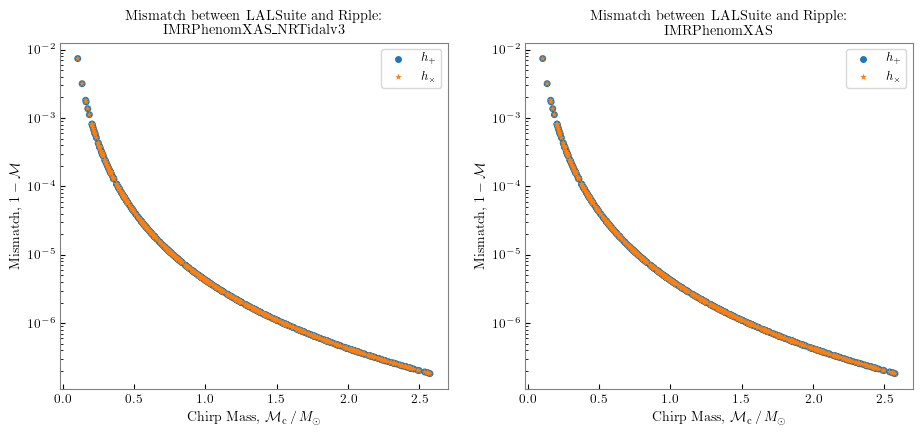

In [102]:
chirp_mass, _ = ms_to_Mc_eta(jnp.array([mass_1, mass_2]))
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
ax = axes[0]
ax.scatter(chirp_mass, 1 - Tidalv3_match_hp, label=r'$h_+$')
ax.scatter(chirp_mass, 1 - Tidalv3_match_hc, marker='*', label=r'$h_\times$')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel(r'Chirp Mass, ${\cal M}_{\rm c}\,/\,M_\odot$')
ax.set_ylabel(r'Mismatch, $1 - {\cal M}$')
ax.set_title('Mismatch between LALSuite and Ripple:' + '\n' + 'IMRPhenomXAS_NRTidalv3')

ax = axes[1]
ax.scatter(chirp_mass, 1 - XAS_match_hp, label=r'$h_+$')
ax.scatter(chirp_mass, 1 - XAS_match_hc, marker='*', label=r'$h_\times$')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel(r'Chirp Mass, ${\cal M}_{\rm c}\,/\,M_\odot$')
ax.set_ylabel(r'Mismatch, $1 - {\cal M}$')
ax.set_title('Mismatch between LALSuite and Ripple:' + '\n' + 'IMRPhenomXAS')

### Waveform plots

Just to be sure...

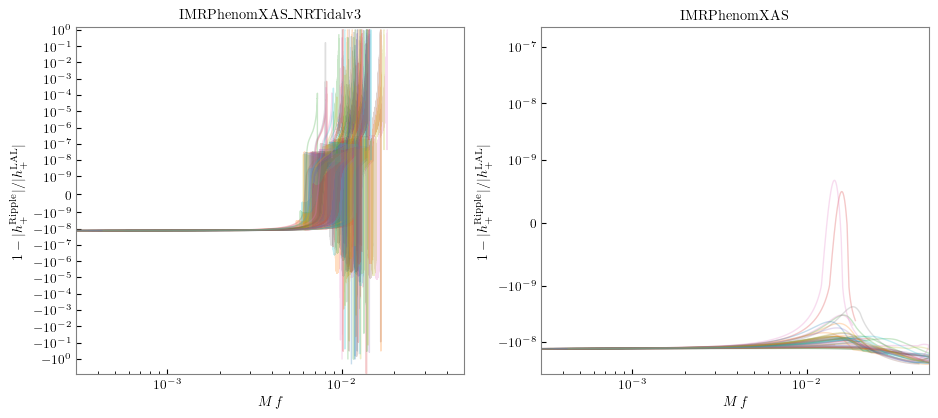

In [97]:
f_mask = frequencies >= 9
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
NRTidal_diff = 1 - jnp.abs(ripple_Tidalv3_hpc[0]) / jnp.abs(lal_Tidalv3_hpc[0])
XAS_diff = 1 - jnp.abs(ripple_XAS_hpc[0]) / jnp.abs(lal_XAS_hpc[0])

ax = axes[0]
ax.set_title('IMRPhenomXAS_NRTidalv3')
for Mtot, diff in zip(total_mass[::10], NRTidal_diff[::10]):
    non_zero = diff != 0
    mask = f_mask & non_zero
    ax.plot(Mtot * MTSUN_SI * frequencies[mask], diff[mask], alpha=0.25)
    ax.set_ylabel(r'$1 - |h_+^{\rm Ripple}| / |h_+^{\rm LAL}|$')

ax = axes[1]
ax.set_title('IMRPhenomXAS')
for Mtot, diff in zip(total_mass[::10], XAS_diff[::10]):
    non_zero = diff != 0
    mask = f_mask & non_zero
    ax.plot(Mtot * MTSUN_SI * frequencies[mask], diff[mask], alpha=0.25)
    ax.set_ylabel(r'$1 - |h_+^{\rm Ripple}| / |h_+^{\rm LAL}|$')

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1e-9)
    ax.set_xlabel(r'$M\,f$')
    ax.set_xlim(3e-4, 5e-2)

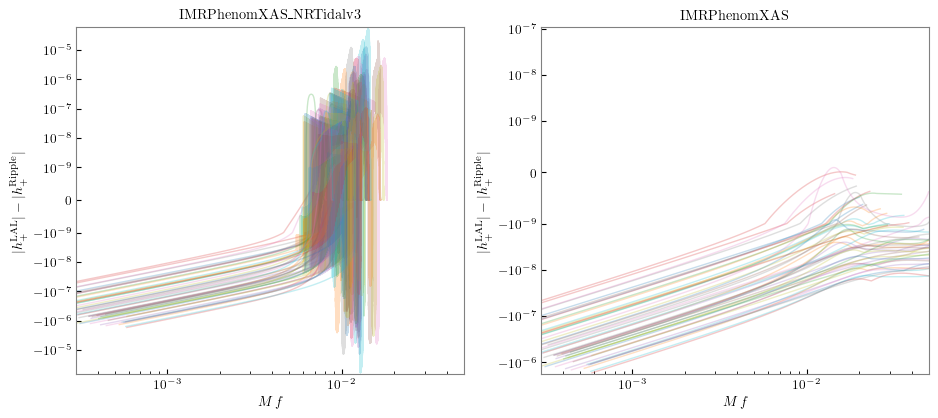

In [99]:
f_mask = frequencies > 9
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
NRTidal_diff = jnp.abs(lal_Tidalv3_hpc[0]) - jnp.abs(ripple_Tidalv3_hpc[0]) 
XAS_diff = jnp.abs(lal_XAS_hpc[0]) - jnp.abs(ripple_XAS_hpc[0]) 

ax = axes[0]
ax.set_title('IMRPhenomXAS_NRTidalv3')
for Mtot, diff in zip(total_mass[::10], NRTidal_diff[::10]):
    non_zero = diff != 0
    mask = f_mask & non_zero
    ax.plot(Mtot * MTSUN_SI * frequencies[mask], diff[mask], alpha=0.25)
    ax.set_ylabel(r'$|h_+^{\rm LAL}| - |h_+^{\rm Ripple}|$')

ax = axes[1]
ax.set_title('IMRPhenomXAS')
for Mtot, diff in zip(total_mass[::10], XAS_diff[::10]):
    non_zero = diff != 0
    mask = f_mask & non_zero
    ax.plot(Mtot * MTSUN_SI * frequencies[mask], diff[mask], alpha=0.25)
    ax.set_ylabel(r'$|h_+^{\rm LAL}| - |h_+^{\rm Ripple}|$')

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=1e-9)
    ax.set_xlabel(r'$M\,f$')
    ax.set_xlim(3e-4, 5e-2)

## Test `XAS_NRTidalv3` $\Lambda_{1,2} \to 0$ limit

In [54]:
seed = 20
Nsamples = 500
duration = 16.0
f_min = 5.0
f_max = fs / 2

rand_arr = jax.random.uniform(jax.random.PRNGKey(seed), 
                              (6, Nsamples), dtype=jnp.float64)
total_mass = rand_arr[0] * 5.5 + 0.5
mass_ratio = rand_arr[1] * 0.95 + 0.05
mass_1 = total_mass / (1 + mass_ratio)
mass_2 = total_mass - mass_1
spin_1z, spin_2z = rand_arr[2:4] * 2 - 1
inclination = rand_arr[4] * jnp.pi
phase = rand_arr[5] * 2 * jnp.pi
Lambda_1, Lambda_2 = jnp.zeros((2, Nsamples))

thetas = jnp.vstack([
    mass_1, mass_2, spin_1z, spin_2z, inclination, phase, Lambda_1, Lambda_2
])

lal_XAS_wfms, lal_Tidalv3_wfms = [], []
for theta in thetas.T:
    _, *lal_hpc = lal_NRTidalv3_waveform(
        *np.array(theta), duration=duration,
        f_min=f_min, f_max=f_max,
        reference_frequency=f_min
    )
    lal_Tidalv3_wfms.append(lal_hpc)
    _, *lal_hpc = lal_XAS_waveform(
        *np.array(theta), duration=duration,
        f_min=f_min, f_max=f_max,
        reference_frequency=f_min
    )
    lal_XAS_wfms.append(lal_hpc)

_, *ripple_XAS_hpc = ripple_XAS_waveform(
    *thetas, duration=duration,
    f_min=f_min, f_max=f_max,
    reference_frequency=f_min
)
_, *ripple_Tidalv3_hpc = ripple_NRTidalv3_waveform(
    *thetas, duration=duration,
    f_min=f_min, f_max=f_max,
    reference_frequency=f_min
)

lal_XAS_hpc = jnp.array(lal_XAS_wfms).transpose(1,0,2)
lal_Tidalv3_hpc = jnp.array(lal_Tidalv3_wfms).transpose(1,0,2)
ripple_XAS_hpc = jnp.array(ripple_XAS_hpc)
ripple_Tidalv3_hpc = jnp.array(ripple_Tidalv3_hpc)

frequencies = get_freq_array(sampling_freqs=fs, duration=duration)
interp_psd = jnp.interp(frequencies, psd_freqs, psd_arr)
lal_match_hp = compute_match(lal_XAS_hpc[0], lal_Tidalv3_hpc[0], interp_psd, frequencies)
lal_match_hc = compute_match(lal_XAS_hpc[1], lal_Tidalv3_hpc[1], interp_psd, frequencies)
ripple_match_hp = compute_match(ripple_XAS_hpc[0], ripple_Tidalv3_hpc[0], interp_psd, frequencies)
ripple_match_hc = compute_match(ripple_XAS_hpc[1], ripple_Tidalv3_hpc[1], interp_psd, frequencies)

Text(0.5, 1.0, 'Mismatch between XAS and XAS_NRTidalv3 in Ripple')

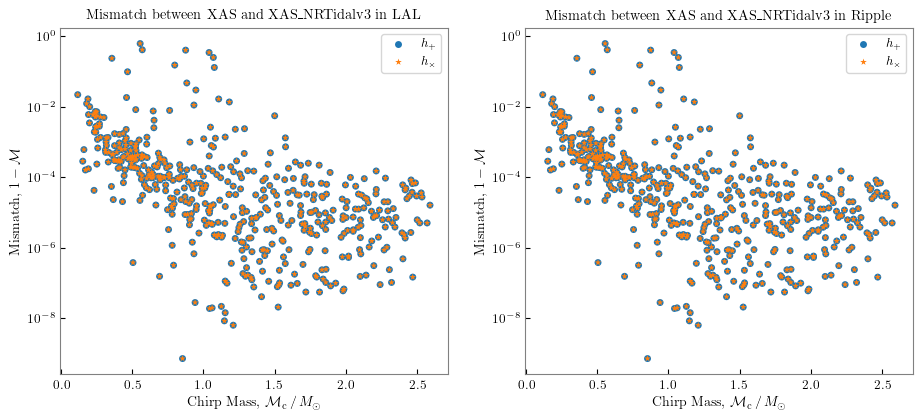

In [ ]:
chirp_mass, _ = ms_to_Mc_eta(jnp.array([mass_1, mass_2]))
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
ax = axes[0]
ax.scatter(chirp_mass, 1 - lal_match_hp, label=r'$h_+$')
ax.scatter(chirp_mass, 1 - lal_match_hc, marker='*', label=r'$h_\times$')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel(r'Chirp Mass, ${\cal M}_{\rm c}\,/\,M_\odot$')
ax.set_ylabel(r'Mismatch, $1 - {\cal M}$')
ax.set_title('Mismatch between XAS and XAS_NRTidalv3 in LAL' + '\n' + r'in the $\Lmabda_{1,2} \to 0$ limit')

ax = axes[1]
ax.scatter(chirp_mass, 1 - ripple_match_hp, label=r'$h_+$')
ax.scatter(chirp_mass, 1 - ripple_match_hc, marker='*', label=r'$h_\times$')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel(r'Chirp Mass, ${\cal M}_{\rm c}\,/\,M_\odot$')
ax.set_ylabel(r'Mismatch, $1 - {\cal M}$')
ax.set_title('Mismatch between XAS and XAS_NRTidalv3 in Ripple' + '\n' + r'in the $\Lmabda_{1,2} \to 0$ limit')

Well, okay, this is surprising...

But they are consistently bad, and that's more important :p

## Waveform plots 

(Just to be sure...)

## Misc.

In [12]:
thetas.shape

(8, 20)

In [14]:
lal_hpc.shape

(2, 20, 32769)

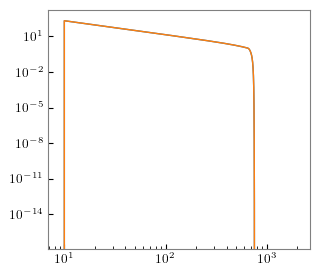

In [17]:
idx = 8
mask = frequencies >= 9
plt.loglog(frequencies[mask], jnp.abs(lal_hpc[0][idx][mask]), label='LAL h+')
plt.loglog(frequencies[mask], jnp.abs(ripple_hpc[0][idx][mask]), label='Ripple h+')

In [51]:
lalsim.SimInspiralChooseFDWaveform?

Docstring: SimInspiralChooseFDWaveform(REAL8 const m1, REAL8 const m2, REAL8 const S1x, REAL8 const S1y, REAL8 const S1z, REAL8 const S2x, REAL8 const S2y, REAL8 const S2z, REAL8 const distance, REAL8 const inclination, REAL8 const phiRef, REAL8 const longAscNodes, REAL8 const eccentricity, REAL8 const meanPerAno, REAL8 const deltaF, REAL8 const f_min, REAL8 const f_max, REAL8 f_ref, Dict LALpars, Approximant const approximant) -> int
Type:      builtin_function_or_method